# SVM Lineal con *scorings* de docking
## Proteína CDK2 y datasets CSAR y DUD2006
Prueba de SVM con los scorings calculados con:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import warnings
warnings.filterwarnings('ignore')
import glob, os, sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

Carga del DataFrame Principal:

In [2]:
# Nombre de la proteina de interes
prot_name = 'cdk2'

In [3]:
patho_to_json_file = glob.glob((os.path.join('.', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO_LABELS_AUC_docking_DUD.json')))[0]
df_cdk2_labels = pd.read_json(patho_to_json_file)
#df_cdk2_labels.head()

In [4]:
df_auc_scores_vrd8x = df_cdk2_labels[['AUC_vrd_8x', 'AUC_vrd_DUD_8x']]

Carga de los dataframes con los mejores scores de las proteínas para cada programa de *docking*.

## Ensemble Docking con ligandos CSAR
- ### 111 ligandos
    - 27 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [5]:
# Vinardo scoring 16x
patho_to_vrd16_file = glob.glob((os.path.join('.', 'data', 
                       'vs_docking_crys_ensemble_VINARDO.csv')))[0]

df_vinardo_results = pd.read_csv(patho_to_vrd16_file, index_col=0)
y_CSAR = pd.Series(df_vinardo_results.ActiveInactive == "Active", dtype = int)
X_CSAR = df_vinardo_results.drop(["ActiveInactive"], axis = 1)

print("Dims X_CSAR", X_CSAR.shape)

Dims X_CSAR (111, 402)


## Ensemble Docking con ligandos DUD (2006)
- ### 2146 ligandos
    - 72 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [6]:
# Carga de los datos DUD
# Split de los sets de entrenamiento y prueba
patho_to_json_vrd8_file = glob.glob((os.path.join('.', 'data', 
                       'vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv')))[0]


df_vrd_DUD2006 = pd.read_csv(patho_to_json_vrd8_file, index_col=0)
y_DUD = pd.Series(df_vrd_DUD2006.Actividad == "Active", dtype = int)
X_DUD = df_vrd_DUD2006.drop(["Actividad"], axis = 1)

print("Dims X_DUD", X_DUD.shape)

Dims X_DUD (2146, 402)


### Ploting function

In [15]:
sns.set( context = 'talk', style = 'white', palette = "Set2")

def plot_roc_and_swarm(y_true, y_score, df = None, 
                       mask_filtered_columns = None, filter_name = 'Filter', plot_swarm = False):   
    fpr, tpr, thresholds = roc_curve(y_true = y_true, y_score = y_score)
    auc = roc_auc_score( y_true = y_true, y_score = y_score)
    
    n_cols, fig_width = (121, 15) if plot_swarm else (111, 7)
    fig, (ax1, ax2) = plt.subplots(figsize = (fig_width, 7), ncols=2)
    plt.subplot(n_cols)
    plt.grid(linestyle='--', linewidth='0.8')
    plt.xlabel("FPR (1 - specificity)")
    plt.ylabel("TPR (sensitivity)")
    plt.title('ROC AUC')
    plt.plot(fpr, tpr, label='AUC = %0.3f' % auc, lw = 4)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    if plot_swarm:
        data = df
        data = data.melt()
        data[filter_name] = np.tile(mask_filtered_columns, 2)
        plt.subplot(122)
        plt.grid(linestyle='--', linewidth='0.8')
        sns.swarmplot(x = "variable", y = "value", data= data, 
                          hue = filter_name)
        plt.xlabel("Benchmarks usados (CSAR / DUD)"); plt.ylabel("AUC")
        plt.title('AUC por conformación')
        plt.legend()


# SVM Lineal con Vinardo 16x
## Dataset Completo

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

### Función para ejecutar el SVM
1. Recibe como entrada los sets de entrenamiento y de prueba.
2. Crea un *Pipeline* para trabajar sobre el *X_train*.
    - Estandariza los datos del X_train.
    - Crea la instancia del clasificador lineal.
3. Lleva a cabo el *Grid search* para  determinar los mejores parámetros del modelo (*C*).
4. Obtiene el mejor modelo al finalizar el *Grid search*.
5. El *mejor modelo* es usado para predecir sobre *X_test*.
    - Se obtiene **y_pred** con las predicciones (1 = activo y 0 = inactivo).
    - Se obtiene **y_score** con las distancias de las predicciones al hiperplano. +Estas se usarán para calcular las curvas ROC.
6. Se imprimen algunas métricas de **y_pred** vs **y_test**.
7. Se grafica la curva ROC.

In [185]:
def run_SVM(X_train, X_test, y_train, y_test, C = None, verbose = False):
    #
    print("X_train dims:", X_train.shape)
    print("X_tets dims:", X_test.shape)
    if verbose:
        print('')
        # Imprimimos cuantos positivos y negativos tenemos en cada set
        print(F'Set de Entrenamiento: {y_train.sum()}/{len(y_train)} activos.')
        print(F'Set de Prueba: {y_test.sum()}/{len(y_test)} activos.')
        print('')
    
    # Determina el mejor modelo usando grid search y validación cruzada
    SVCpipe = Pipeline([
            ("scaler", StandardScaler()), # Realiza la estandarización sobre el X_train
            ("SVC", SVC(kernel='linear', probability = True))])
    
    if C is None: c_intervals = [0.001, 0.1, 1, 10, 100]
    else: c_intervals = C
    parametros = {'SVC__C': c_intervals}
    linear_SVC = GridSearchCV(SVCpipe, parametros, 
                              scoring = 'roc_auc',
                              refit=True, iid = False, cv = 5, return_train_score = True)
    # Entrenamiento con el grid
    linear_SVC.fit(X_train, y_train)
    
    # Realiza la estandarización sobre el X_test
    y_train_pred = linear_SVC.predict(X_train)
    
    # Predicciones sobre X_test
    y_pred = linear_SVC.predict(X_test) # Valores predichos
    y_score = linear_SVC.decision_function(X_test) # Distancia al hiperplano
    # Genera algunos outputs
    if verbose:
        print('C:', linear_SVC.best_params_, '\n')
        print('Train Accuracy: %.3f' % metrics.accuracy_score(y_true = y_train, 
                                                        y_pred = y_train_pred))
        print('Train AUC: %.3f' % roc_auc_score(y_true = y_train, 
                                          y_score = y_train_pred), '\n')
        print('MÉTRICAS')
        print("Accuracy: %.3f" % metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
        print("Precision: %.3f" % metrics.precision_score(y_true = y_test, y_pred = y_pred))
        print("Recall: %.3f" % metrics.recall_score(y_true = y_test, y_pred = y_pred))
        print('')
        # Matirz de confusión
        print('Matriz de confusión:\n', confusion_matrix(y_true = y_test, y_pred = y_pred))
        # AUC
        print("\nAUC ROC: %.3f" % roc_auc_score(y_true = y_test, y_score = y_score))
    return(y_test, y_score)

***
# Modelos con CDK2
## Primer modelo
### CSAR (train) / CSAR (test) - Todas las conformaciones
Usamos sólo los resultados del Ensemble Docking con los ligandos de CSAR.

X_train dims: (88, 402)
X_tets dims: (23, 402)


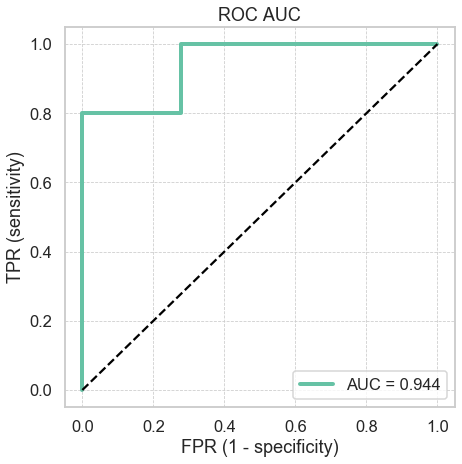

In [186]:
# Split del dataset para obtener train y test
X_train, X_test, y_train, y_test = train_test_split(X_CSAR , y_CSAR, 
                                                    test_size = 0.2, stratify = y_CSAR)
# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score)

### Modelo Alternativo:
#### Sólo se entrena y valida con una fracción de CSAR y se evalúa con DUD

X_train dims: (99, 402)
X_tets dims: (2146, 402)


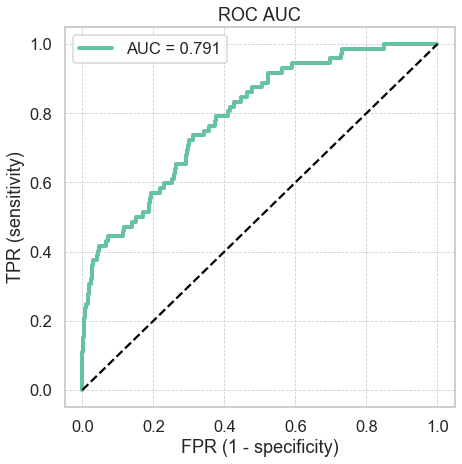

In [187]:
# Split del dataset para obtener train y test
X_train, X_test, y_train, y_test = train_test_split(X_CSAR , y_CSAR, 
                                                    test_size = 0.1, stratify = y_CSAR)
X_test = X_DUD
y_test = y_DUD
# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score)

## Segundo Modelo
### CSAR (train) / DUD (test) - Todas las conformaciones
No necesitamos hacer el split, ahora CSAR servirá como conjunto de entrenamiento y validación, y DUD como conjunto de prueba.

X_train dims: (111, 402)
X_tets dims: (2146, 402)


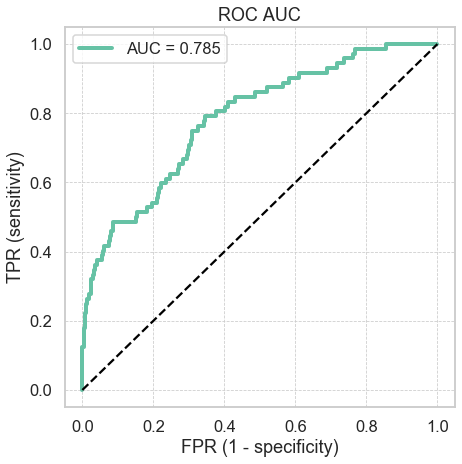

In [188]:
X_train = X_CSAR
y_train = y_CSAR
X_test = X_DUD
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score)

## Tercer Modelo
### CSAR (train) / DUD (test) - Conformaciones del frente  con 5 objetivos
Se incluyen 25 conformaciones

X_train dims: (111, 25)
X_tets dims: (2146, 25)


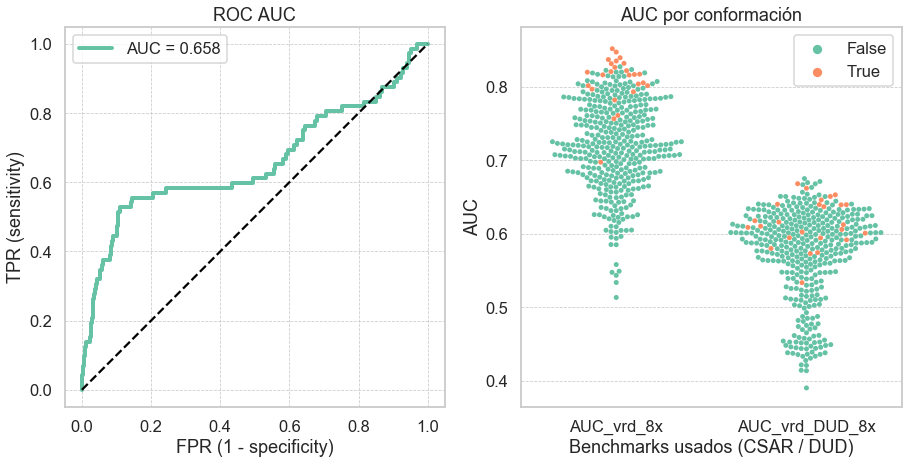

In [189]:
conformaciones_fp_5obj = [ '1ckp', '1h07', '1ke9', '1oiq', '1pxm', '1urw', '1vyz', '2c4g', '2r3p',
       '2r64', '2vv9', '2w05', '3eid', '3ezv', '3lfn', '3qu0', '3s0o', '3s2p',
       '3unj', '3unk', '4bzd', '4cfn', '4eor', '4fkq', '6guf']
filtro = [True if i in conformaciones_fp_5obj else False for i in X_CSAR.columns]

X_train = X_CSAR[ conformaciones_fp_5obj ]
y_train = y_CSAR
X_test = X_DUD[ conformaciones_fp_5obj ]
y_test = y_DUD

y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Confs. Pareto", plot_swarm= True )

## Cuarto Modelo
### CSAR (train) / DUD (test) - Las 25 mejores conformaciones de vinardo a 16x evaluando CSAR
Se incluyen 25 conformaciones

X_train dims: (111, 25)
X_tets dims: (2146, 25)


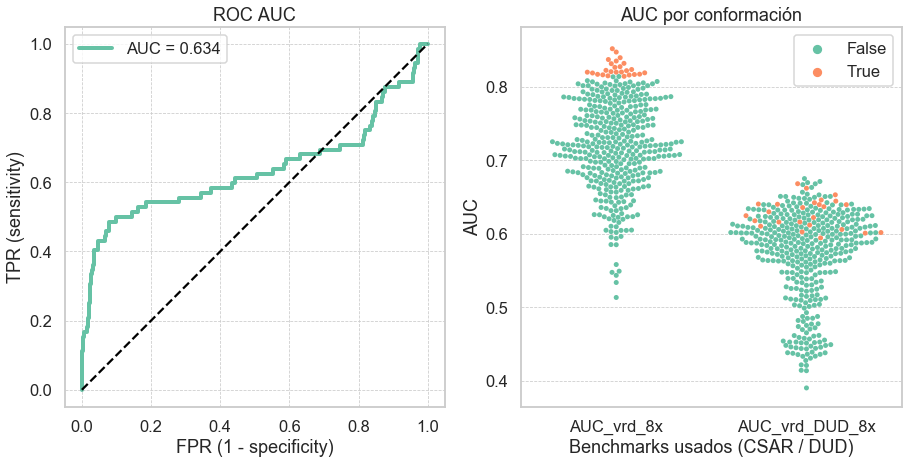

In [190]:
confs_vrd_25_best = df_cdk2_labels.AUC_vrd_8x.sort_values(ascending=False).index[:25]
filtro = [True if i in confs_vrd_25_best else False for i in X_CSAR.columns]

X_train = X_CSAR[ confs_vrd_25_best ]
y_train = y_CSAR

X_test = X_DUD[ confs_vrd_25_best ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Mejores 25 Vrd8x", plot_swarm= True )

## Quinto Modelo
### CSAR (train) / DUD (test) - Mejores conformaciones en DUD evaluado con vinardo 8x

X_train dims: (111, 25)
X_tets dims: (2146, 25)


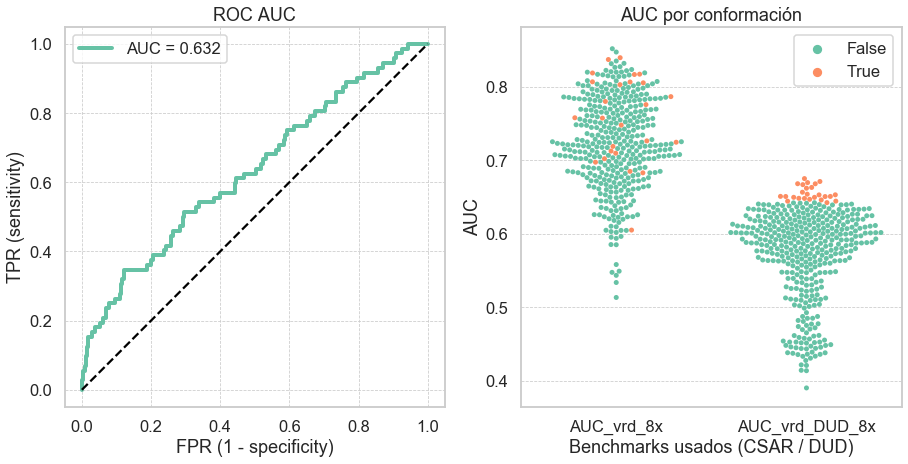

In [191]:
confs_vrd_25_best = df_cdk2_labels.AUC_vrd_DUD_8x.sort_values(ascending=False).index[:25]
filtro = [True if i in confs_vrd_25_best else False for i in X_CSAR.columns]

X_train = X_CSAR[ confs_vrd_25_best ]
y_train = y_CSAR

X_test = X_DUD[ confs_vrd_25_best ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Mejores 25 Vrd8x DUD", plot_swarm= True )

## Sexto Modelo
### CSAR (train) / DUD (test) - Conformaciones con AUC arriba de la media de AUCs con CSAR

In [16]:
df_cdk2_labels.AUC_vrd_8x.describe()

count    402.000000
mean       0.723992
std        0.062214
min        0.513348
25%        0.683258
50%        0.723303
75%        0.773303
max        0.851584
Name: AUC_vrd_8x, dtype: float64

X_train dims: (111, 200)
X_tets dims: (2146, 200)


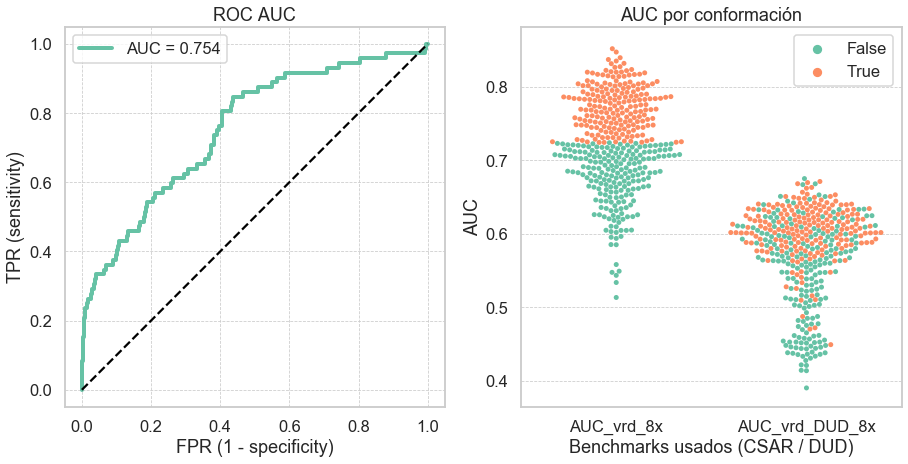

In [192]:
_, media_auc, std_auc, *_ = tuple(df_cdk2_labels.AUC_vrd_8x.describe())
up = media_auc + std_auc
down = media_auc - std_auc
filtro = np.array((df_cdk2_labels.AUC_vrd_8x >= media_auc))

X_train = X_CSAR.iloc[:, filtro ]
y_train = y_CSAR

X_test = X_DUD.iloc[:, filtro ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Confs con AUC > media", plot_swarm= True )

## Séptimo Modelo
### CSAR (train) / DUD (test) - Conformaciones con AUC a +/- 1 sd de la media de AUCs con CSAR

X_train dims: (111, 269)
X_tets dims: (2146, 269)


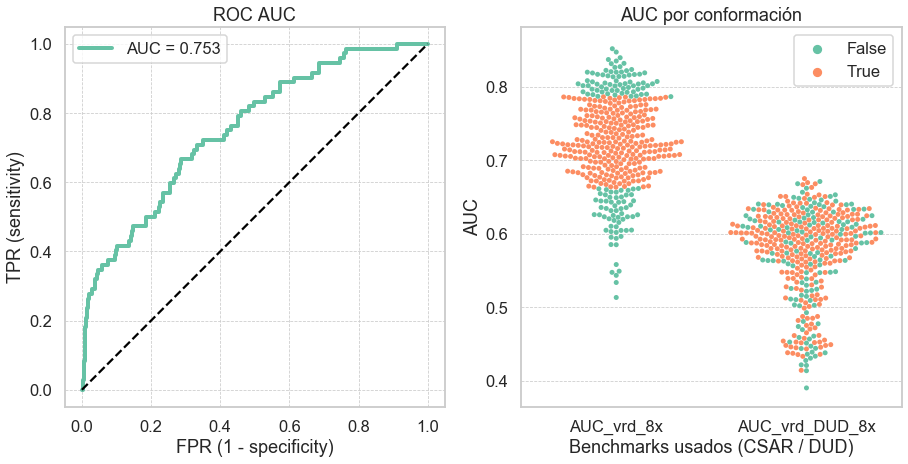

In [193]:
_, media_auc, std_auc, *_ = tuple(df_cdk2_labels.AUC_vrd_8x.describe())
up = media_auc + std_auc
down = media_auc - std_auc
filtro = np.array((df_cdk2_labels.AUC_vrd_8x >= down) & (df_cdk2_labels.AUC_vrd_8x <= up))

X_train = X_CSAR.iloc[:, filtro ]
y_train = y_CSAR

X_test = X_DUD.iloc[:, filtro ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Confs. AUC u+/-1s", plot_swarm= True )

## Octavo Modelo
### CSAR (train) / DUD (test) - Conformaciones activas

X_train dims: (111, 114)
X_tets dims: (2146, 114)


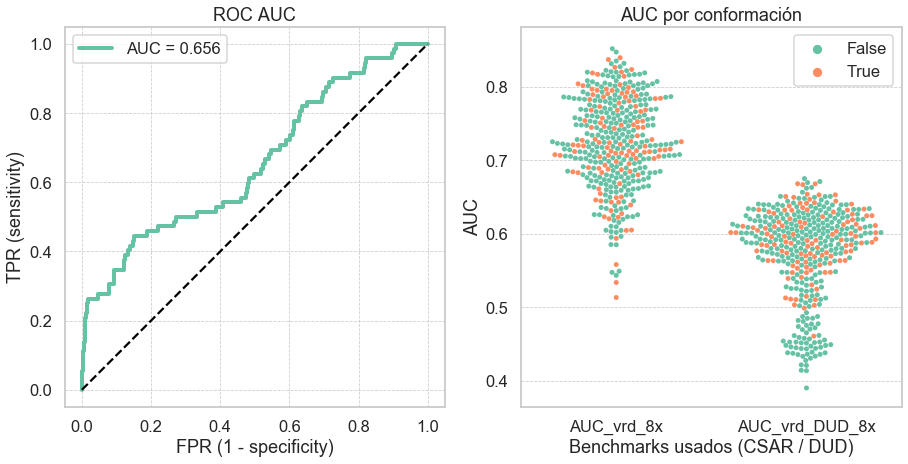

In [194]:
active_confs = df_cdk2_labels[df_cdk2_labels.Labels_conf == "active"].index
filtro = df_cdk2_labels.Labels_conf == "active"
X_train = X_CSAR[ active_confs ]
y_train = y_CSAR

X_test = X_DUD[ active_confs ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Confs. Activas", plot_swarm= True )

## Noveno Modelo
### CSAR (train) / DUD (test) - Conformaciones NO activas

X_train dims: (111, 288)
X_tets dims: (2146, 288)


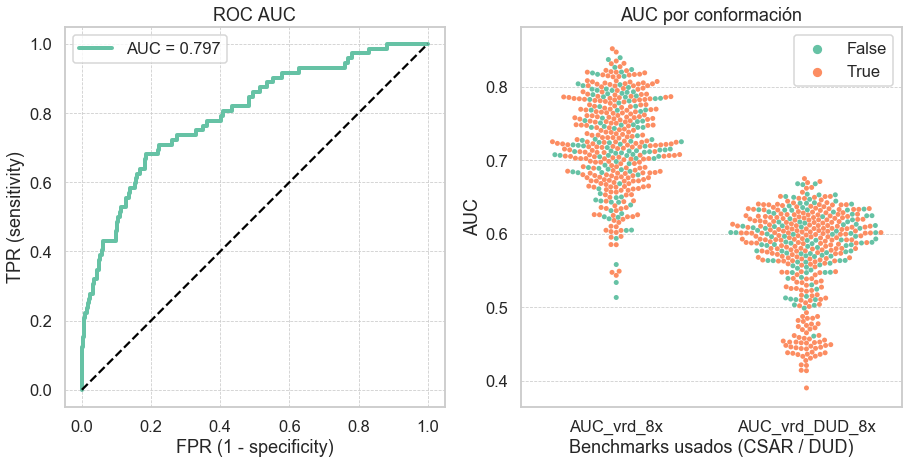

In [195]:
inactive_confs = df_cdk2_labels[df_cdk2_labels.Labels_conf != "active"].index
filtro = df_cdk2_labels.Labels_conf != "active"
X_train = X_CSAR[ inactive_confs  ]
y_train = y_CSAR

X_test = X_DUD[ inactive_confs  ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Confs. Inactivas", plot_swarm= True )

# Feature Selection CSAR DATASET

## Removemos conformaciones con menor varianza
Here in with will use the VarianceThereshold method from sklearn. The method removes all those features whose variance doesn't meet some thereshold, 1.2 in this case.

In [197]:
from sklearn.feature_selection import VarianceThreshold

Number of filtered columns: 140

X_train dims: (111, 140)
X_tets dims: (2146, 140)


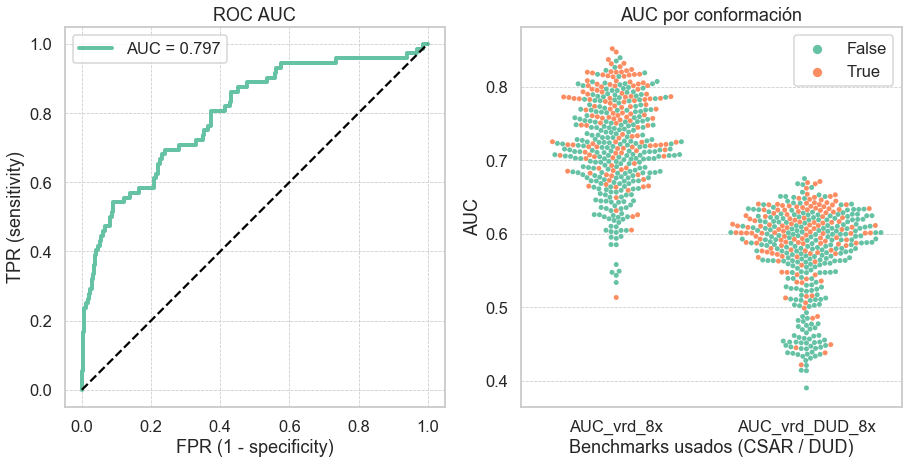

In [198]:
# Definimos los datasets
X_train = X_CSAR
y_train = y_CSAR
X_test = X_DUD
y_test = y_DUD

# Definimos el estimador de varianza unicamente sobre el X_train (CSAR)
sel = VarianceThreshold(threshold = 1.22)
sel.fit_transform(X_train)
filtered_columns = sel.get_support()

print(F'Number of filtered columns: {filtered_columns.sum()}\n')

# Now we update the datasets
X_train_hv = X_train.iloc[:, filtered_columns]
X_test_hv = X_test.iloc[:, filtered_columns]

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train_hv, X_test_hv, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtered_columns, 
                   filter_name = "Confs. var > 1.22", plot_swarm= True )

# Pendiente:
## Wrapper method Backward elimination

### Recursive Feature Elimination (RFE)
As the name sugest, we fit all the possible features to the model at first. Then we check the performance of the model and then, iteartively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

In [199]:
from sklearn.feature_selection import RFE, RFECV

Number of filtered columns: 25

X_train dims: (111, 25)
X_tets dims: (2146, 25)


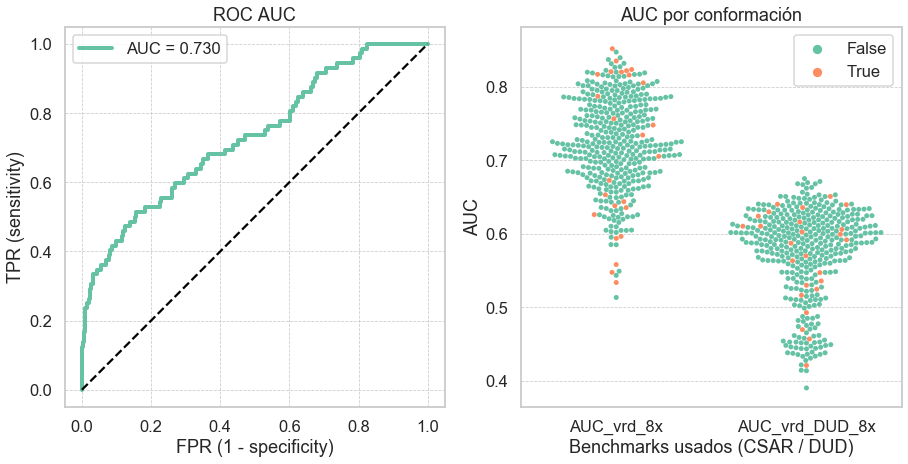

In [200]:
X_train = X_CSAR
y_train = y_CSAR
X_test = X_DUD
y_test = y_DUD

estimador = SVC(kernel="linear", C = 0.1, probability = True)
selector = RFE(estimador, n_features_to_select = 25, step = 1)
# Estandarización del X_train para el selector
X_train_std = StandardScaler().fit_transform(X_train)
selector.fit(X_train_std, y_train)
filtered_columns = selector.get_support()

print(F'Number of filtered columns: {filtered_columns.sum()}\n')

# Now we update the datasets
X_train_hv = X_train.iloc[:, filtered_columns]
X_test_hv = X_test.iloc[:, filtered_columns]

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train_hv, X_test_hv, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtered_columns, 
                   filter_name = "Confs. Inactivas", plot_swarm= True)

In [203]:
# Intalación de yellowbrick para facilitar las visualizaciones
# !conda install -c districtdatalabs yellowbrick -y

In [183]:
# REFCV
X_train = X_CSAR
y_train = y_CSAR
X_test = X_DUD
y_test = y_DUD

classifier = SVC(kernel='linear', probability = True, C = 0.1)

# Determina el mejor modelo usando grid search y validación cruzada
SVCpipe = Pipeline([
        ("scaler", StandardScaler()), # Realiza la estandarización sobre el X_train
        ("rfecv", RFECV(estimator = classifier, scoring = 'roc_auc', cv = 5) )])
SVCpipe.fit(X_train, y_train)
y_train_pred = SVCpipe.predict(X_train)
# Predicciones sobre X_test
y_pred = SVCpipe.predict(X_test) # Valores predichos
y_score = SVCpipe.decision_function(X_test) # Distancia al hiperplano
auc =roc_auc_score(y_true = y_test, y_score = y_score)

SVCpipe["rfecv"].n_features_
features_mask = SVCpipe["rfecv"].support_
print(features_mask.sum())
print(auc)

159
0.7727820636451302


159
0.7727820636451302


AttributeError: 'Pipeline' object has no attribute 'show'

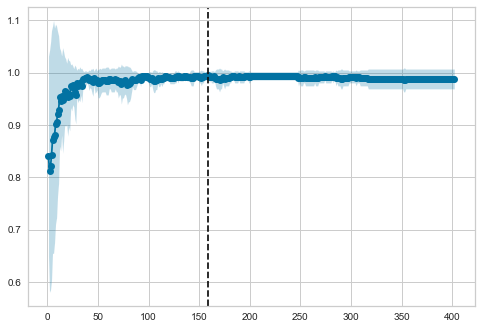

In [205]:
from yellowbrick.model_selection import RFECV as RFECV_yellowbrick

X_train = X_CSAR
y_train = y_CSAR
X_test = X_DUD
y_test = y_DUD

classifier = SVC(kernel='linear', probability = True, C = 0.1)

# Determina el mejor modelo usando grid search y validación cruzada
SVCpipe = Pipeline([
        ("scaler", StandardScaler()), # Realiza la estandarización sobre el X_train
        ("rfecv", RFECV_yellowbrick(model = classifier, scoring = 'roc_auc', cv = 5) )])
#SVCpipe.fit(X_train, y_train)
y_train_pred = SVCpipe.predict(X_train)
# Predicciones sobre X_test
y_pred = SVCpipe.predict(X_test) # Valores predichos
y_score = SVCpipe.decision_function(X_test) # Distancia al hiperplano
auc =roc_auc_score(y_true = y_test, y_score = y_score)

SVCpipe["rfecv"].n_features_
features_mask = SVCpipe["rfecv"].support_
print(features_mask.sum())
print(auc)

In [226]:
SVCpipe["rfecv"].draw()

In [222]:
%matplotlib inline
SVCpipe["rfecv"].draw()

In [ ]:
############

In [179]:
# RFE
def run_RFE_by_range(X_train, X_test, y_train, y_test, C = 1,
                        min_features = 2, max_features = 10):
    classifier = SVC(kernel='linear', probability = True, C = C)
    # Arreglo de AUCs
    auc_scores = pd.DataFrame(columns=['n_features', 'auc', 'features_mask'])
    for i in range(min_features, max_features + 1):
        # Determina el mejor modelo usando grid search y validación cruzada
        SVCpipe = Pipeline([
                ("scaler", StandardScaler()), # Realiza la estandarización sobre el X_train
                ("rfe", RFE( estimator = classifier, n_features_to_select = i, step = 1) )])
        SVCpipe.fit(X_train, y_train)
        y_train_pred = SVCpipe.predict(X_train)
        # Predicciones sobre X_test
        y_pred = SVCpipe.predict(X_test) # Valores predichos
        y_score = SVCpipe.decision_function(X_test) # Distancia al hiperplano
        auc =roc_auc_score(y_true = y_test, y_score = y_score)

        n_features = SVCpipe["rfe"].n_features_
        features_mask = SVCpipe["rfe"].support_
        #
        auc_scores.loc[i] = [n_features, auc, features_mask]
    return(auc_scores)

In [178]:
# REF
X_train = X_CSAR
y_train = y_CSAR
X_test = X_DUD
y_test = y_DUD
# Ejecutamos el RFE de 2 a 402 conformacioens
# df_RFE_402 = run_RFE_by_range(X_train, X_test, y_train, y_test, max_features = 402, C = 0.1)
# descomentar para volver a ejecutar

### Guardamos o leemos los resultados para no tener que recalcularlso

In [128]:
# df_RFE_402.to_json('./data/RFE_2_to_402_features_CSAR_train_DUD_test.json')

In [176]:
df_RFE_402 = pd.read_json('./data/RFE_2_to_402_features_CSAR_train_DUD_test.json')

In [177]:
max_auc_model = df_RFE_402.loc[df_RFE_402.auc.idxmax()]
print(F'{max_auc_model.n_features} conforamaciones => AUC = {max_auc_model.auc}')
# Modelo máximo con menos de 50 features
max_auc_model_50f = df_RFE_402.loc[df_RFE_402[:50].auc.idxmax()]
print(F'{max_auc_model_50f.n_features} conforamaciones => AUC = {max_auc_model_50f.auc}')

242 conforamaciones => AUC = 0.7939502304
34 conforamaciones => AUC = 0.754312654


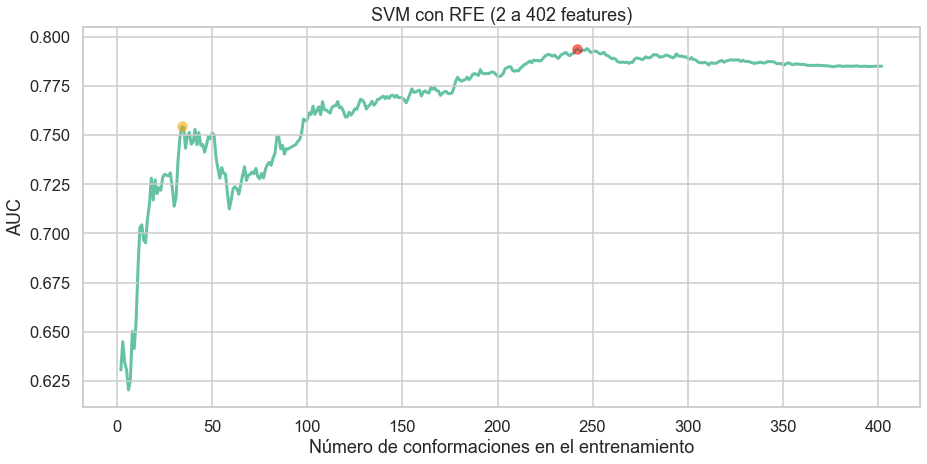

In [184]:
# gráfica de AUC
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = df_RFE_402.n_features, y = df_RFE_402.auc, linewidth = 3, zorder = 0)
plt.scatter(max_auc_model_50f.n_features, max_auc_model_50f.auc, c = 'orange', alpha = 0.5)
plt.scatter(max_auc_model.n_features, max_auc_model.auc, c = 'red', alpha = 0.5)
plt.xlabel('Número de conformaciones en el entrenamiento')
plt.ylabel('AUC')
plt.title('SVM con RFE (2 a 402 features)')
plt.show()

### Visualizamos las dos selecciones

X_train dims: (111, 242)
X_tets dims: (2146, 242)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

C: {'SVC__C': 0.1} 

Train Accuracy: 1.000
Train AUC: 1.000 

MÉTRICAS
Accuracy: 0.918
Precision: 0.182
Recall: 0.417

Matriz de confusión:
 [[1939  135]
 [  42   30]]

AUC ROC: 0.794


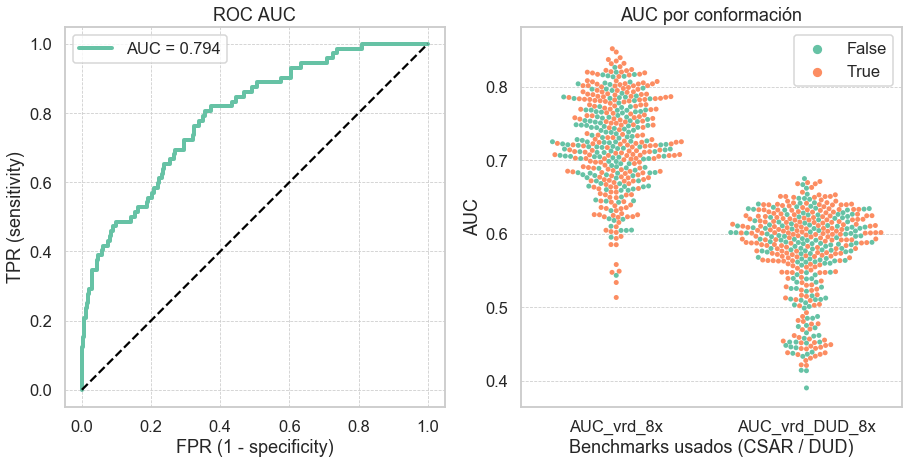

In [175]:
# Datasets originales
X_train = X_CSAR; y_train = y_CSAR; X_test = X_DUD; y_test = y_DUD

# Conformaciones seleccionadas
filtered_columns = max_auc_model.features_mask

# Datasets actualizados con las features seleccionadas
X_train_hv = X_train.iloc[:, filtered_columns]
X_test_hv = X_test.iloc[:, filtered_columns]

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train_hv, X_test_hv, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtered_columns, 
                   filter_name = "Confs. Inactivas", plot_swarm= True)

X_train dims: (111, 34)
X_tets dims: (2146, 34)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

C: {'SVC__C': 0.1} 

Train Accuracy: 1.000
Train AUC: 1.000 

MÉTRICAS
Accuracy: 0.884
Precision: 0.123
Recall: 0.403

Matriz de confusión:
 [[1867  207]
 [  43   29]]

AUC ROC: 0.754


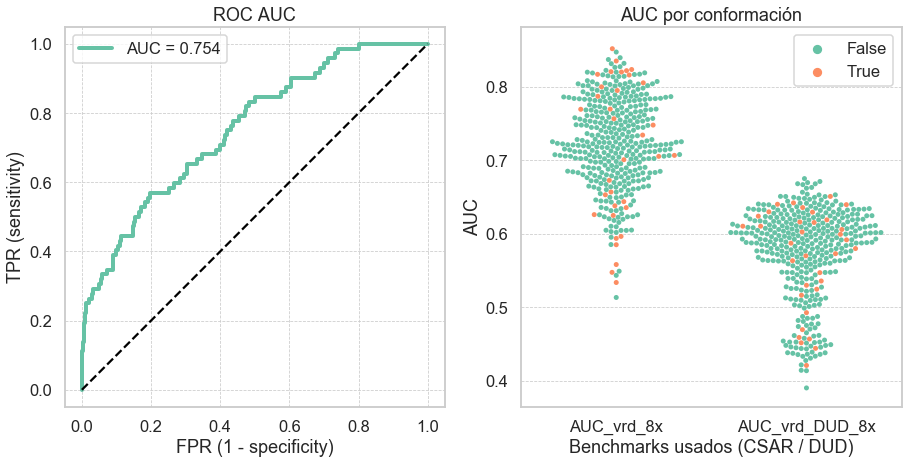

In [180]:
# Datasets originales
X_train = X_CSAR; y_train = y_CSAR; X_test = X_DUD; y_test = y_DUD

# Conformaciones seleccionadas
filtered_columns = max_auc_model_50f.features_mask

# Datasets actualizados con las features seleccionadas
X_train_hv = X_train.iloc[:, filtered_columns]
X_test_hv = X_test.iloc[:, filtered_columns]

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train_hv, X_test_hv, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtered_columns, 
                   filter_name = "Confs. Inactivas", plot_swarm= True)